
# **Comparison between ShapeMask and Mask-RCNN** 

---
Project by: Neeti Yadav & Robby Moebius







Our aim was to find the differences and similarities between the two state of the art instance segmentation techniques *ShapeMask* and *Mask-RCNN*.

The flowchart for the two techniques explaining how they work is given below.



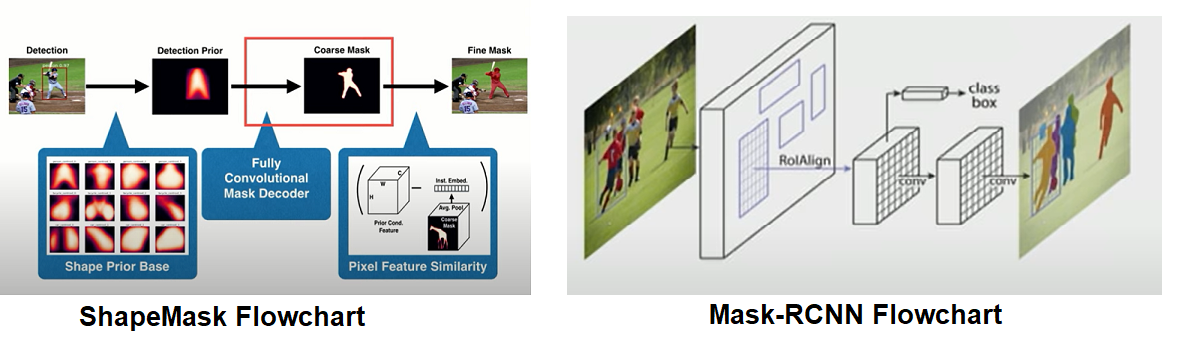

*Source: ICCV19: Oral Session 4.2A - Segmentation, Detection, 3D Scene Understanding*

## Clone ShapeMask from Git

In [ ]:
!git clone -b shapemask https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10023, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 10023 (delta 119), reused 125 (delta 68), pack-reused 9798
Receiving objects: 100% (10023/10023), 24.38 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (7157/7157), done.


##Importing libraries

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
import tensorflow.compat.v1 as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/detection')
sys.path.insert(0, 'tpu/models/official/detection/utils')
from utils.object_detection import visualization_utils
from evaluation import coco_utils

## ID Mapping in COCO dataset

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Images from video

**About the image**:
* The following images are screenshots from a video of a person playing basketball. 
* These images were chosen too see how the techniques detect objects and their masks for different positions of the ball relative to the body.

In [ ]:
image_path_1 = 'dribble2.jpg'
image_path_2 = 'dribble3.JPG'
image_path_3 = 'dribble4.JPG'

with open(image_path_1, 'rb') as f:
  np_image_string_1 = np.array([f.read()])
  
image = Image.open(image_path_1)
width, height = image.size
np_image_1 = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

with open(image_path_2, 'rb') as f:
  np_image_string_2 = np.array([f.read()])
  
image = Image.open(image_path_2)
width, height = image.size
np_image_2 = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

with open(image_path_3, 'rb') as f:
  np_image_string_3 = np.array([f.read()])
  
image = Image.open(image_path_3)
width, height = image.size
np_image_3 = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

    


ValueError: ignored

In [ ]:

display.display(display.Image(image_path_1, width=1024))
display.display(display.Image(image_path_2, width=1024))
display.display(display.Image(image_path_3, width=1024))


## Shapemask technique on video images

In [ ]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_1})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_1 * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_1 = 'test_results1_shapemask.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_1)
#display.display(display.Image(output_image_1, width=1024))

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_2})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_2 * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_2 = 'test_results2_shapemask.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_2)
#display.display(display.Image(output_image_2, width=1024))

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_3})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_3 * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_3 = 'test_results3_shapemask.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_3)


In [ ]:
display.display(display.Image(output_image_1, width=1024))
display.display(display.Image(output_image_2, width=1024))
display.display(display.Image(output_image_3, width=1024))

###**Observations**:

* In the first and second images baseball glove has been identified which is but an extension of the individual's body i.e. his hand.
* Furtheremore, in the second image the technique fails to detect the ball when it is in front of his body.

## Mask-RCNN technique on video images

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
use_tpu_2 = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_1})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_4 = 'test_results1_rcnn.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_4)
#display.display(display.Image(output_image_4, width=1024))

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_2})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_2,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_5 = 'test_results2_rcnn.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_5)
#display.display(display.Image(output_image_5, width=1024))

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_3})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_3,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_6 = 'test_results3_rcnn.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_6)
#display.display(display.Image(output_image_6, width=1024))

In [ ]:
display.display(display.Image(output_image_4, width=1024))
display.display(display.Image(output_image_5, width=1024))
display.display(display.Image(output_image_6, width=1024))

### **Observations**:

* In the first image the ball is not identified by the Mask-RCNN technique and is considered as part of the individual's body.
* In the second image, a tennis racket is falsely detected (42% chance) but the ball is detected correctly when in front of the body.
* For the third image masks produced for the ball and body by ShapeMask are more precise.

### **Inference**:

* ShapeMask heavily relies on heatmap and shape priors for object detection and that may have led to:
 - categorising the individual's hand as a baseball glove as it slightly resembles so in the first picture
 - failing to detect the ball when in front of the individual's body
* Since ShapeMask looks at similarities between neighboring pixels the masks detected are better in this case.

## Image with animals

###**About the image**:

* This image was chosen to understand how the two instance segmentation techniques work with animals in categorising and detecting their masks.

In [ ]:
image_path_7 = 'animals.jpg'

with open(image_path_7, 'rb') as f:
  np_image_string_7 = np.array([f.read()])
  
image = Image.open(image_path_7)
width, height = image.size
np_image_7= np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
display.display(display.Image(image_path_7,width=1024))

## Shapemask technique on animal image

In [ ]:
use_tpu_3 = True #@param {type:"boolean"}
if use_tpu_3:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_7})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_7 * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_7 = 'test_results7_shapemask.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_7)
display.display(display.Image(output_image_7, width=1024))

## Mask-RCNN technique on animal image

In [ ]:
use_tpu_4 = True #@param {type:"boolean"}
if use_tpu_4:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_7})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_7,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_7 = 'test_results7_rcnn.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_7)
display.display(display.Image(output_image_7, width=1024))

###**Observations and Inference**:
* In Mask R-CNN box detections are made and within the box masking is done for each object whereas in ShapeMask boxes are needed to approximately localize the object of interest and not required to produce accurate masks.

* Above mentioned reason is why we observe:
  - Inaccurate masking of the zebras in the second case and no part of the two zebras is unmasked in the first case.
  - Left ear of the deer in the picture wasn't accurately masked in the second case as it was out of the detection box.


## Baseball image

###**About the image**:
* This image of a baseball player was chosen to note the masking precision of the two techniques.

In [ ]:
image_path_8 = 'base.jpeg'

with open(image_path_8, 'rb') as f:
  np_image_string_8 = np.array([f.read()])
  
image = Image.open(image_path_8)
width, height = image.size
np_image_8= np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
display.display(display.Image(image_path_8,width=1024))

## Shapemask technique on baseball image

In [ ]:
use_tpu_6 = True #@param {type:"boolean"}
if use_tpu_6:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_8})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
# Use outer boxes 
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_8 * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_8 = 'test_results8_shapemask.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_8)
display.display(display.Image(output_image_8, width=1024))

## Mask-RCNN technique on baseball image

In [ ]:
use_tpu_5 = True #@param {type:"boolean"}
if use_tpu_5:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string_8})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.13    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image_8,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_8 = 'test_results8_rcnn.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_8)
display.display(display.Image(output_image_8, width=1024))

###**Observations and Inference**:
* Pixel wise detection helps ShapeMask in achieving highly accurate masks especially at places where the body bends and on edges.

##**Major differences**

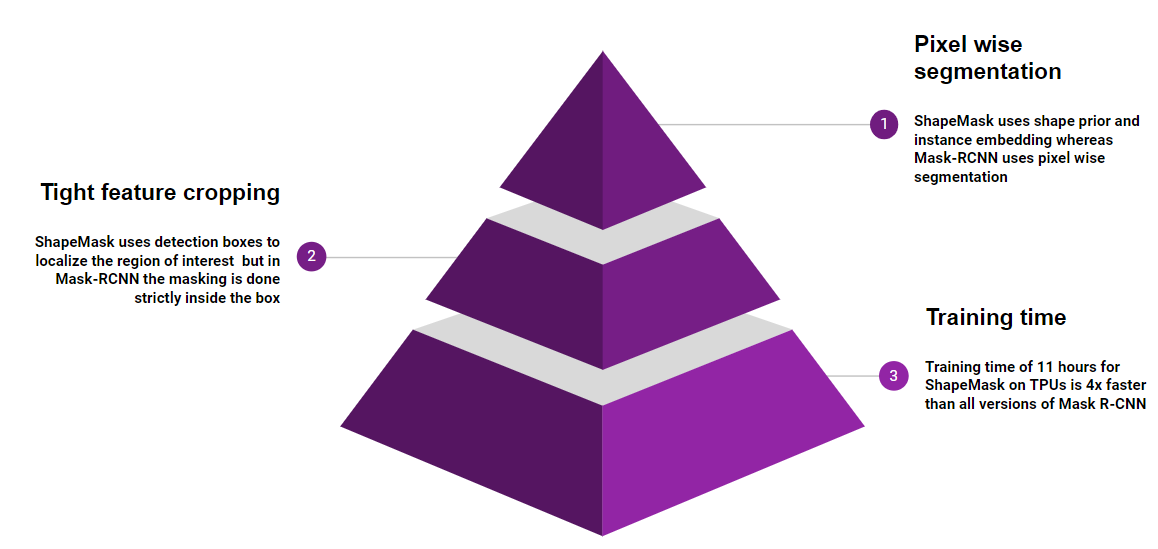

##**References**:
* Kuo, W., Angelova, A., Malik, J., & Lin, T. (2019). ShapeMask: Learning to Segment Novel Objects by Refining Shape Priors. 2019 IEEE/CVF International Conference on Computer Vision (ICCV). doi:10.1109/iccv.2019.00930

* Get Handles Basketball. (2019, May 2). Why Dribbling Is HARD When Running! Ball Handling For Beginners [Video]. Youtube. https://www.youtube.com/watch?v=oBoSOpN-TWM&t=76s

*  Kaiming He, Georgia Gkioxari, Piotr Dollar, and Ross Girshick. Mask r-cnn. 2017 IEEE International Conference on Computer Vision (ICCV),  on, pages 2980–2988. IEEE, 2017

* Tsung-Yi Lin, Michael Maire, Serge Belongie, James Hays, Pietro Perona, Deva Ramanan, Piotr Dollar, and C Lawrence ´ Zitnick. Microsoft coco: Common objects in context. In European conference on computer vision, pages 740–755. Springer, 2014